In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="darkgrid")
mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

In [2]:
df_analyse=pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')  
df_analyse.sort_values('date',ascending=True).head()

,date,Italy,US,Spain,Germany,"Korea, South"
0,2020-01-22,0,1,0,0,1
1,2020-01-23,0,1,0,0,1
2,2020-01-24,0,2,0,0,2
3,2020-01-25,0,2,0,0,2
4,2020-01-26,0,5,0,0,3


In [3]:
N0=1000000 
beta=0.4   
gamma=0.1 


# condition I0+S0+R0=N0
I0=df_analyse.Germany[35]
S0=N0-I0
R0=0

In [4]:
def SIR_model(SIR,beta,gamma):
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0  
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])


# Simulative approach to calculate SIR curves

In [5]:

SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)


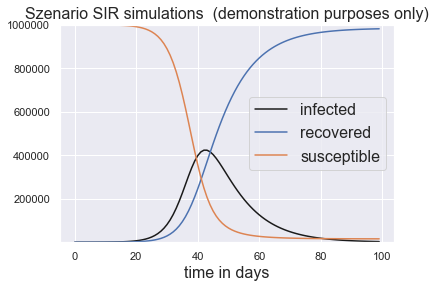

In [6]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

# Fitting the parameters of SIR model

In [7]:


ydata = np.array(df_analyse.Germany[35:])
t=np.arange(len(ydata))

In [8]:
I0=ydata[0]
S0=N0-I0
R0=0
beta

0.4

In [9]:
def SIR_model_t(SIR,t,beta,gamma):    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [10]:
def fit_odeint(x, beta, gamma):

    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [11]:

popt=[0.4,0.1]
fit_odeint(t, *popt)

array([2.70000000e+01, 3.64457071e+01, 4.91956207e+01, 6.64053493e+01,
       8.96344660e+01, 1.20987564e+02, 1.63304428e+02, 2.20416326e+02,
       2.97491205e+02, 4.01498275e+02, 5.41832616e+02, 7.31153728e+02,
       9.86509149e+02, 1.33083608e+03, 1.79496099e+03, 2.42024936e+03,
       3.26209305e+03, 4.39445723e+03, 5.91573047e+03, 7.95611026e+03,
       1.06866705e+04, 1.43300301e+04, 1.91720581e+04, 2.55731545e+04,
       3.39761277e+04, 4.49053964e+04, 5.89492486e+04, 7.67139399e+04,
       9.87375269e+04, 1.25356226e+05, 1.56531317e+05, 1.91671801e+05,
       2.29519056e+05, 2.68172791e+05, 3.05306626e+05, 3.38543581e+05,
       3.65876662e+05, 3.85989183e+05, 3.98379367e+05, 4.03287154e+05,
       4.01494345e+05, 3.94088591e+05, 3.82258097e+05, 3.67146745e+05,
       3.49770632e+05, 3.30982618e+05, 3.11468385e+05, 2.91760020e+05,
       2.72257377e+05, 2.53251232e+05, 2.34945074e+05, 2.17474127e+05,
       2.00921199e+05, 1.85329524e+05, 1.70712933e+05, 1.57063815e+05,
      

In [12]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])



C:\Users\prajw\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors :  [0.00682684 0.00613471]  start infect: 27
Optimal parameters: beta = 0.41715861804629045  and gamma =  0.20293328515306866


In [13]:
fitted=fit_odeint(t, *popt)

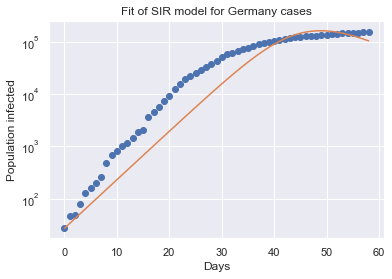

Optimal parameters: beta = 0.41715861804629045  and gamma =  0.20293328515306866
Basic Reproduction Number R0  2.055644138080334
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [14]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

# Dynamic beta in SIR (infection rate)

In [15]:
t_initial=28
t_intro_measures=14
t_hold=21
t_relax=21

beta_max=0.4
beta_min=0.11
gamma=0.1
pd_beta=np.concatenate((np.array(t_initial*[beta_max]),
                       np.linspace(beta_max,beta_min,t_intro_measures),
                       np.array(t_hold*[beta_min]),
                        np.linspace(beta_min,beta_max,t_relax),
                       ))




In [16]:
pd_beta

array([0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.37769231,
       0.35538462, 0.33307692, 0.31076923, 0.28846154, 0.26615385,
       0.24384615, 0.22153846, 0.19923077, 0.17692308, 0.15461538,
       0.13230769, 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.1245    ,
       0.139     , 0.1535    , 0.168     , 0.1825    , 0.197     ,
       0.2115    , 0.226     , 0.2405    , 0.255     , 0.2695 

In [17]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_beta in pd_beta:
   
    new_delta_vec=SIR_model(SIR,each_beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

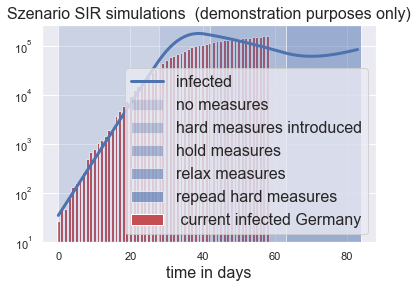

In [18]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',linewidth=3)

t_phases=np.array([t_initial,t_intro_measures,t_hold,t_relax]).cumsum()
ax1.bar(np.arange(len(ydata)),ydata, width=0.8,label=' current infected Germany',color='r')
ax1.axvspan(0,t_phases[0], facecolor='b', alpha=0.2,label='no measures')
ax1.axvspan(t_phases[0],t_phases[1], facecolor='b', alpha=0.3,label='hard measures introduced')
ax1.axvspan(t_phases[1],t_phases[2], facecolor='b', alpha=0.4,label='hold measures')
ax1.axvspan(t_phases[2],t_phases[3], facecolor='b', alpha=0.5,label='relax measures')
ax1.axvspan(t_phases[3],len(propagation_rates.infected), facecolor='b', alpha=0.6,label='repead hard measures')

ax1.set_ylim(10, 1.5*max(propagation_rates.infected))
ax1.set_yscale('log')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

In [ ]:
import pandas as pd
import numpy as np

import dash
dash.__version__
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output,State

import plotly.graph_objects as go

import os
print(os.getcwd())
df_input_large=pd.read_csv('../data/processed/COVID_final_set.csv',sep=';')


fig = go.Figure()

app = dash.Dash()
app.layout = html.Div([

    dcc.Markdown('''
    #  Dashboard Implementation of COVID Data SIR modelling

    '''),

    dcc.Markdown('''
    ## Select Multiple countries for viewing the respective graph
    '''),


    dcc.Dropdown(
        id='country_drop_down',
        options=[ {'label': each,'value':each} for each in df_input_large['country'].unique()],
        value=['US', 'Germany','Italy'], # which are pre-selected
        multi=True
    ),

    dcc.Markdown('''
        ## The timeline of confirmed COVID-19 cases or the approximate doubling time
        '''),


    dcc.Dropdown(
    id='doubling_time',
    options=[
        {'label': 'Timeline Confirmed ', 'value': 'confirmed'},
        {'label': 'Timeline Confirmed Filtered', 'value': 'confirmed_filtered'},
        {'label': 'Timeline Doubling Rate', 'value': 'confirmed_DR'},
        {'label': 'Timeline Doubling Rate Filtered', 'value': 'confirmed_filtered_DR'},
    ],
    value='confirmed',
    multi=False
    ),

    dcc.Graph(figure=fig, id='main_window_slope')
])



@app.callback(
    Output('main_window_slope', 'figure'),
    [Input('country_drop_down', 'value'),
    Input('doubling_time', 'value')])
def update_figure(country_list,show_doubling):


    if 'doubling_rate' in show_doubling:
        my_yaxis={'type':"log",
               'title':'Approximated doubling rate over 3 days'
              }
    else:
        my_yaxis={'type':"log",
                  'title':'Confirmed infected people'
              }


    traces = []
    for each in country_list:

        df_plot=df_input_large[df_input_large['country']==each]

        if show_doubling=='doubling_rate_filtered':
            df_plot=df_plot[['state','country','confirmed','confirmed_filtered','confirmed_DR','confirmed_filtered_DR','date']].groupby(['country','date']).agg(np.mean).reset_index()
        else:
            df_plot=df_plot[['state','country','confirmed','confirmed_filtered','confirmed_DR','confirmed_filtered_DR','date']].groupby(['country','date']).agg(np.sum).reset_index()
       #print(show_doubling)


        traces.append(dict(x=df_plot.date,
                                y=df_plot[show_doubling],
                                mode='markers+lines',
                                opacity=0.9,
                                name=each
                        )
                )

    return {
            'data': traces,
            'layout': dict (
                width=1280,
                height=720,

                xaxis={'title':'Timeline',
                        'tickangle':-45,
                        'nticks':20,
                        'tickfont':dict(size=14,color="#7f7f7f"),
                      },

                yaxis=my_yaxis
        )
    }

if __name__ == '__main__':

    app.run_server(debug=True, use_reloader=False)
